In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# Chargement des données clients
df = pd.read_csv('churn_clients.csv')

# Affichage des premières lignes du dataframe
print("\nPremières lignes du dataframe :\n")
print(df)

# Vérification du nombre de clients
print("\nNombre de Client :", len(df))

# Vérification des valeurs manquantes
print("\nValeurs manquantes dans le dataframe :\n")
print(df.isnull().sum())

# Vérification des doublon
print("\nNombre de doublons :", df.duplicated().sum())


Premières lignes du dataframe :

     Age  Revenu   Sexe  Anciennete  Frequence_utilisation Support_contacte  \
0     56    4343  Femme           8                     23              Oui   
1     69    5070  Homme           9                     26              Oui   
2     46    1580  Femme           8                     10              Non   
3     32    8004  Homme           9                     29              Oui   
4     60    9130  Homme           9                      1              Non   
..   ...     ...    ...         ...                    ...              ...   
495   65    6742  Femme           2                     19              Non   
496   42    6788  Femme           9                     17              Non   
497   57    6408  Femme           3                      9              Non   
498   62    9669  Homme           4                     24              Non   
499   18    1922  Femme           1                      1              Non   

     Score_satisf

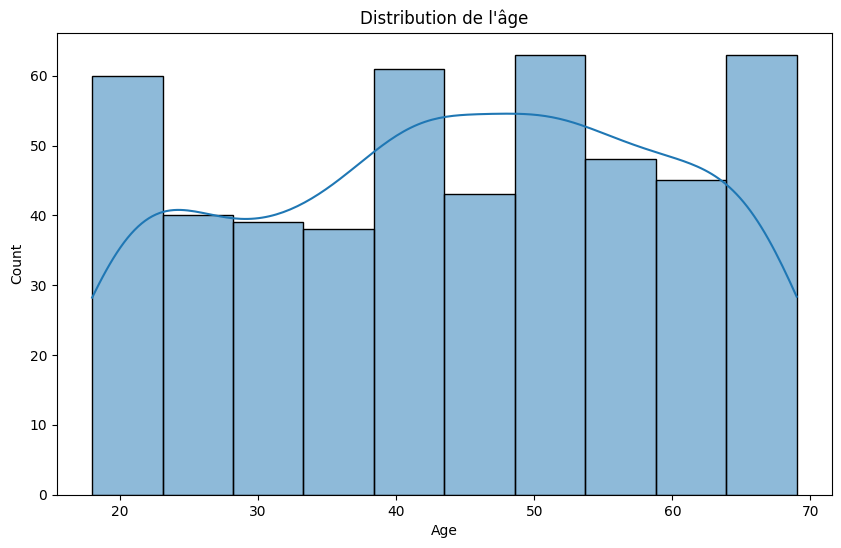

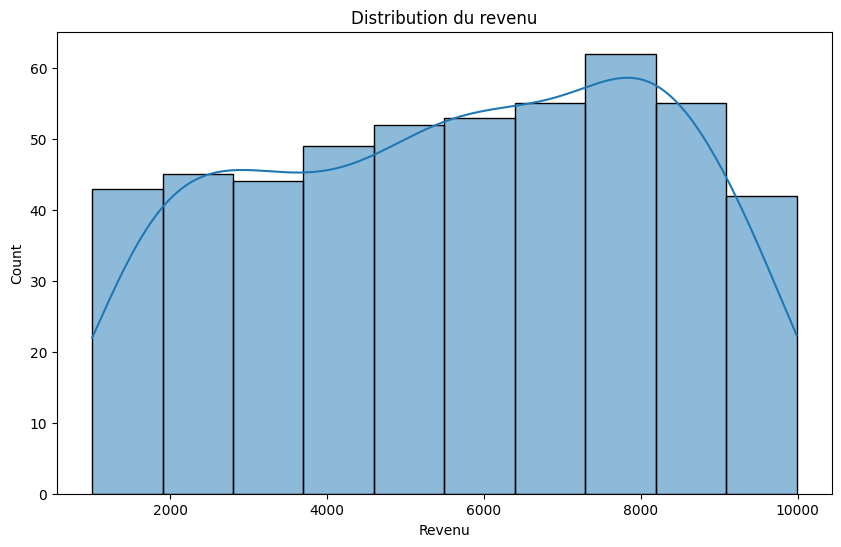

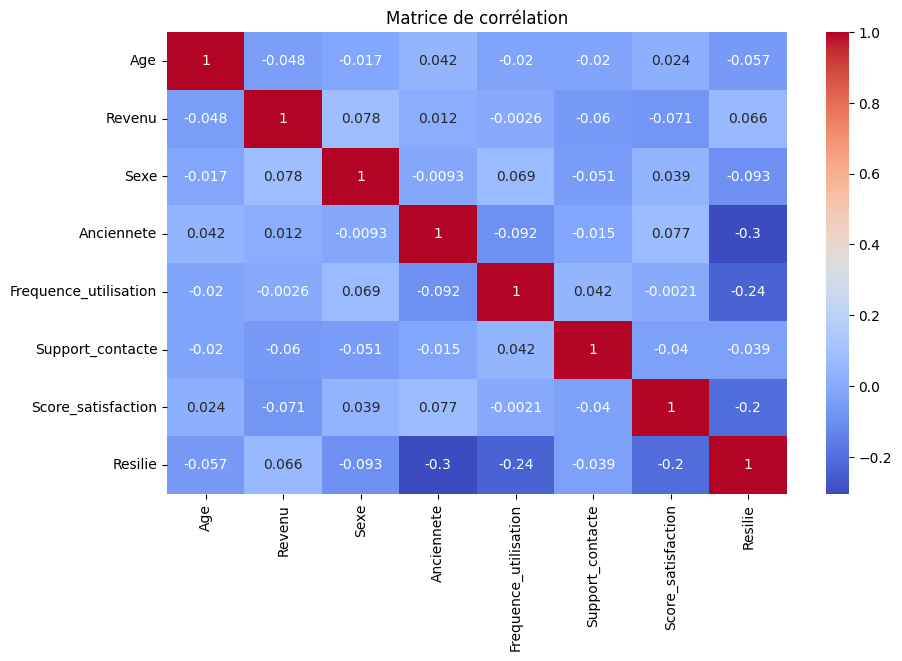


Données après encodage
   Age  Revenu  Sexe  Anciennete  Frequence_utilisation  Support_contacte  \
0   56    4343     0           8                     23                 1   
1   69    5070     1           9                     26                 1   
2   46    1580     0           8                     10                 0   
3   32    8004     1           9                     29                 1   
4   60    9130     1           9                      1                 0   

   Score_satisfaction  Resilie  
0                   2        0  
1                   2        0  
2                   3        0  
3                   3        0  
4                   1        0  


In [ ]:
# Encodage des variables catégorielles
label_encoder = LabelEncoder()
df['Sexe'] = label_encoder.fit_transform(df['Sexe'])
df['Support_contacte'] = label_encoder.fit_transform(df['Support_contacte'])

# Visualisations
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True)
plt.title('Distribution de l\'âge')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['Revenu'], kde=True)
plt.title('Distribution du revenu')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

print("\nDonnées après encodage")
print(df.head())


In [ ]:
# Normalisation des colonnes numériques
scaler = StandardScaler()
df[['Age', 'Revenu', 'Anciennete', 'Frequence_utilisation', 'Score_satisfaction']] = scaler.fit_transform(df[['Age', 'Revenu', 'Anciennete', 'Frequence_utilisation', 'Score_satisfaction']])

print("\nDonnées après standarnisation\n")
print(df.head())



Données après standarnisation

        Age    Revenu  Sexe  Anciennete  Frequence_utilisation  \
0  0.784233 -0.518679     0    1.204281               1.068220   
1  1.649686 -0.230483     1    1.546601               1.417540   
2  0.118500 -1.613983     0    1.204281              -0.445499   
3 -0.813526  0.932610     1    1.546601               1.766860   
4  1.050527  1.378977     1    1.546601              -1.493459   

   Support_contacte  Score_satisfaction  Resilie  
0                 1           -1.240248        0  
1                 1           -1.240248        0  
2                 0           -0.886296        0  
3                 1           -0.886296        0  
4                 0           -1.594201        0  



🔍 Modèle : Régression Logistique
Accuracy (cross-val) : 0.8840
Recall (cross-val) : 0.9600
F1 Score (cross-val) : 0.4701
AUC (cross-val) : 0.9777

--- Évaluation sur le test set ---
Précision : 0.8700
Rappel : 1.0000
F1 Score : 0.4348
AUC : 0.9832
Matrice de confusion :
[[82 13]
 [ 0  5]]

🔍 Modèle : Arbre de Décision
Accuracy (cross-val) : 0.9820
Recall (cross-val) : 0.9200
F1 Score (cross-val) : 0.8372
AUC (cross-val) : 0.9977

--- Évaluation sur le test set ---
Précision : 0.9700
Rappel : 1.0000
F1 Score : 0.7692
AUC : 0.9968
Matrice de confusion :
[[92  3]
 [ 0  5]]

🔍 Modèle : KNN
Accuracy (cross-val) : 0.8940
Recall (cross-val) : 0.8800
F1 Score (cross-val) : 0.4670
AUC (cross-val) : 0.9265

--- Évaluation sur le test set ---
Précision : 0.8800
Rappel : 1.0000
F1 Score : 0.4545
AUC : 1.0000
Matrice de confusion :
[[83 12]
 [ 0  5]]


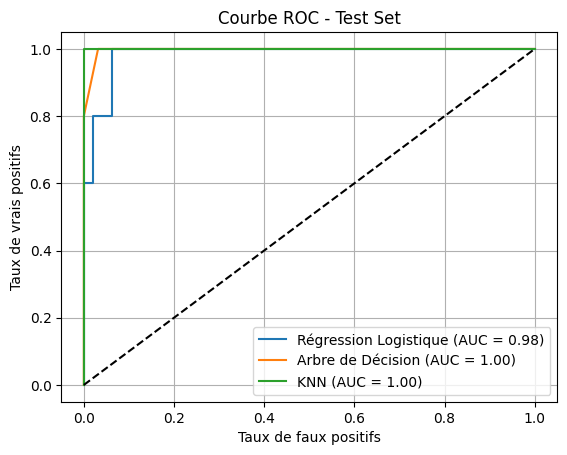

In [ ]:

# 1. Séparation des données
X = df.drop('Resilie', axis=1)
y = df['Resilie']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Définition des modèles avec régularisation
models = {
    'Régression Logistique': LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42),
    'Arbre de Décision': DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=10, weights='distance')
}

# 3. Validation croisée avec Pipeline (scaling + SMOTE)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"\n🔍 Modèle : {model_name}")

    # Pipeline : standardisation -> SMOTE -> modèle
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Cross-val avec 4 scores
    for metric, scorer in {
        'Accuracy': make_scorer(accuracy_score),
        'Recall': make_scorer(recall_score),
        'F1 Score': make_scorer(f1_score),
        'AUC': 'roc_auc'
    }.items():
        cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scorer)
        print(f"{metric} (cross-val) : {cv_scores.mean():.4f}")

# 4. Évaluation sur le test set
    # Préparation : scaling + SMOTE uniquement sur le train
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

    # Entraînement
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)

    # Évaluation finale
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n--- Évaluation sur le test set ---")
    print(f"Précision : {accuracy:.4f}")
    print(f"Rappel : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC : {auc:.4f}")
    print(f"Matrice de confusion :\n{conf_matrix}")

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

# 5. Finalisation de la courbe ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Test Set')
plt.legend(loc='best')
plt.grid(True)
plt.show()


📊 Importance des variables par modèle

🔍 Modèle : Régression Logistique
Anciennete : -1.6550
Frequence_utilisation : -1.2173
Score_satisfaction : -0.7425
Sexe : -0.4749
Revenu : 0.2251
Age : -0.1410
Support_contacte : -0.0585


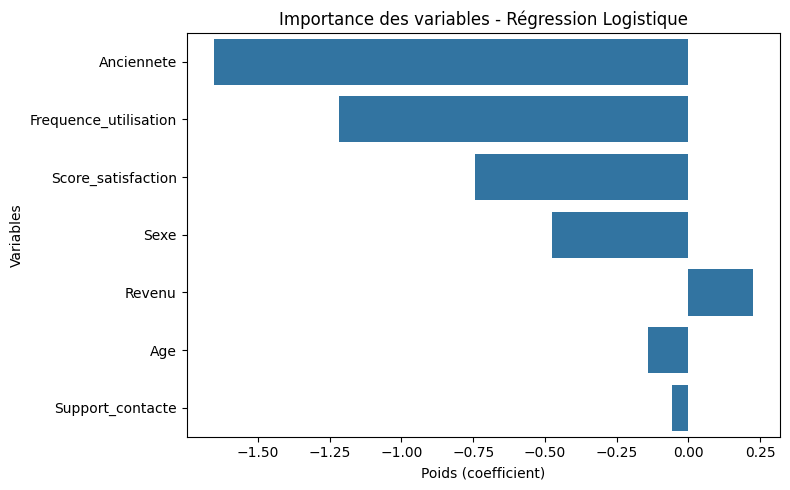


🔍 Modèle : Arbre de Décision
Anciennete : 0.7358
Frequence_utilisation : 0.2501
Score_satisfaction : 0.0142
Sexe : 0.0000
Revenu : 0.0000
Age : 0.0000
Support_contacte : 0.0000


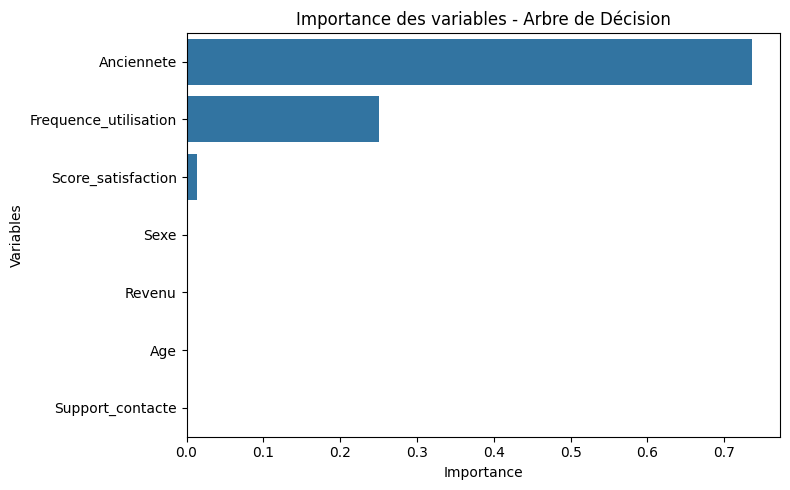


🔍 Modèle : KNN
ℹ️ Le modèle KNN ne donne pas directement l’importance des variables.

🔎 Importance des variables (Permutation) - KNN :
                 Feature  Importance
3             Anciennete    0.048000
4  Frequence_utilisation    0.028667
5       Support_contacte    0.014667
6     Score_satisfaction    0.009333
0                    Age   -0.006667
2                   Sexe   -0.020667
1                 Revenu   -0.023667


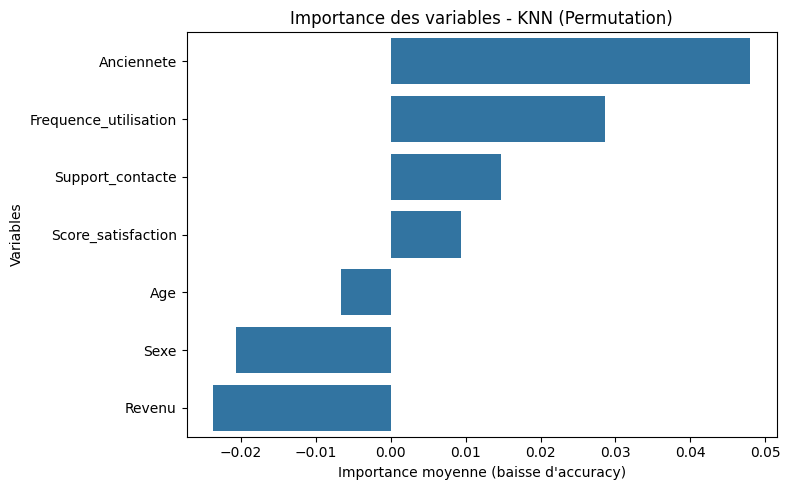

In [ ]:
print("📊 Importance des variables par modèle")

# On reprend les noms de colonnes d'origine
features = X.columns

for model_name, model in models.items():
    print(f"\n🔍 Modèle : {model_name}")

    if model_name == 'Régression Logistique':
        # On récupère les coefficients après entraînement sur données standardisées et SMOTE
        importance = model.coef_[0]
        importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
        importance_df = importance_df.reindex(importance_df.Importance.abs().sort_values(ascending=False).index)

        for _, row in importance_df.iterrows():
            print(f"{row['Feature']} : {row['Importance']:.4f}")

        plt.figure(figsize=(8, 5))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f"Importance des variables - {model_name}")
        plt.xlabel("Poids (coefficient)")
        plt.ylabel("Variables")
        plt.tight_layout()
        plt.show()

    elif model_name == 'Arbre de Décision':
        importance = model.feature_importances_
        importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        for _, row in importance_df.iterrows():
            print(f"{row['Feature']} : {row['Importance']:.4f}")

        plt.figure(figsize=(8, 5))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f"Importance des variables - {model_name}")
        plt.xlabel("Importance")
        plt.ylabel("Variables")
        plt.tight_layout()
        plt.show()

    elif model_name == 'KNN':
        print("ℹ️ Le modèle KNN ne donne pas directement l’importance des variables.")
        # On applique permutation importance ici (sur le modèle déjà entraîné)
        result = permutation_importance(model, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='accuracy')

        perm_importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': result.importances_mean
        }).sort_values(by='Importance', ascending=False)

        print("\n🔎 Importance des variables (Permutation) - KNN :")
        print(perm_importance_df)

        plt.figure(figsize=(8, 5))
        sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
        plt.title("Importance des variables - KNN (Permutation)")
        plt.xlabel("Importance moyenne (baisse d'accuracy)")
        plt.ylabel("Variables")
        plt.tight_layout()
        plt.show()


Accuracy (cross-val) : 0.9800
Recall (cross-val) : 1.0000
F1 Score (cross-val) : 0.8410
AUC (cross-val) : 0.9977

--- Évaluation sur le test set ---
Précision : 0.9700
Rappel : 1.0000
F1 Score : 0.7692
AUC : 0.9968
Matrice de confusion :
[[92  3]
 [ 0  5]]


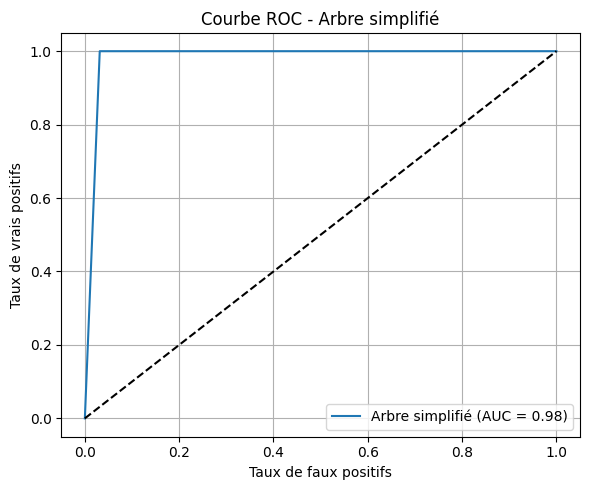


Importance des variables :
                 Feature  Importance
0             Anciennete    0.740827
1  Frequence_utilisation    0.251769
2     Score_satisfaction    0.007404


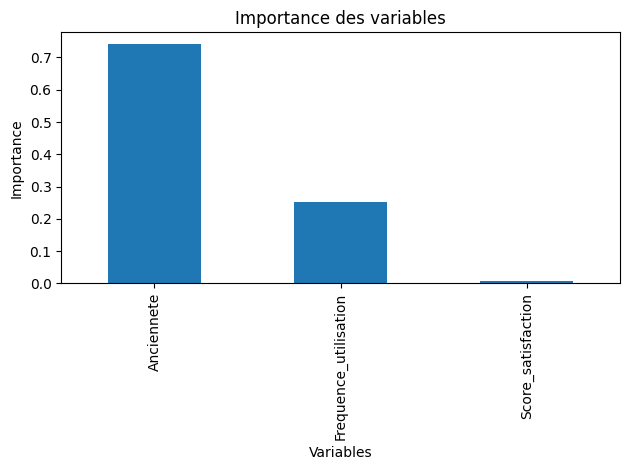

In [ ]:

# Variables à garder selon l'importance
variables_utiles = ['Anciennete', 'Frequence_utilisation', 'Score_satisfaction']

# Nouveau X réduit
X_reduit = df[variables_utiles]
y = df['Resilie']

# 1. Split
X_train, X_test, y_train, y_test = train_test_split(X_reduit, y, test_size=0.2, stratify=y, random_state=42)

# 2. Nouveau modèle arbre
arbre_simplifie = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=42)

# 3. Pipeline (scaling + SMOTE + modèle)
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', arbre_simplifie)
])

# 4. Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for metric, scorer in {
    'Accuracy': make_scorer(accuracy_score),
    'Recall': make_scorer(recall_score),
    'F1 Score': make_scorer(f1_score),
    'AUC': 'roc_auc'
}.items():
    scores = cross_val_score(pipeline, X_reduit, y, cv=cv, scoring=scorer)
    print(f"{metric} (cross-val) : {scores.mean():.4f}")

# 5. Réentraîner sur train + SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

arbre_simplifie.fit(X_train_res, y_train_res)
y_pred = arbre_simplifie.predict(X_test_scaled)

# 6. Évaluer
print("\n--- Évaluation sur le test set ---")
print(f"Précision : {accuracy_score(y_test, y_pred):.4f}")
print(f"Rappel : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print(f"AUC : {roc_auc_score(y_test, arbre_simplifie.predict_proba(X_test_scaled)[:, 1]):.4f}")
print(f"Matrice de confusion :\n{confusion_matrix(y_test, y_pred)}")

# 7. Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Arbre simplifié (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Arbre simplifié')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Affichage de l'importance des variables
importances = arbre_simplifie.feature_importances_
importance_df = pd.DataFrame({
    'Feature': variables_utiles,
    'Importance': importances
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les importances des variables
print("\nImportance des variables :")
print(importance_df)

# Optionnel : Visualiser l'importance des variables
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('Importance des variables')
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


In [ ]:
import shap

# Créer un DataFrame avec les noms des colonnes
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=variables_utiles)

# Créer un explainer SHAP pour l'arbre de décision
explainer = shap.TreeExplainer(arbre_simplifie)

# Obtenir les valeurs SHAP
shap_values = explainer.shap_values(X_test_scaled_df)

# Sélectionner un utilisateur spécifique (par exemple, l'Observation 1)
observation_idx = 0  # Choisis l'indice de l'observation souhaitée (ici, l'utilisateur 1)

# Afficher la prédiction et l'impact des features pour cet utilisateur
prediction = arbre_simplifie.predict([X_test_scaled_df.iloc[observation_idx]])

# Afficher l'explication SHAP
print(f"\n--- Explication de la prédiction pour l'Observation {observation_idx + 1} ---")
print(f"Prédiction : {prediction[0]} (1 signifie résiliation, 0 signifie non résiliation)\n")

# Afficher les valeurs SHAP pour chaque feature (classe 1)
print(f"Valeurs SHAP pour chaque feature (classe 1) :")
for feature, shap_value in zip(variables_utiles, shap_values[1][observation_idx]):
    print(f"{feature}: {shap_value:.4f}")

# Calculer la prédiction attendue (base value) et l'impact total
expected_value = explainer.expected_value[1]
impact_total = expected_value + shap_values[1][observation_idx].sum()

print(f"\nValeur attendue (base value) : {expected_value:.4f}")
print(f"Impact total de l'utilisateur : {impact_total:.4f}")



--- Explication de la prédiction pour l'Observation 1 ---
Prédiction : 0 (1 signifie résiliation, 0 signifie non résiliation)

Valeurs SHAP pour chaque feature (classe 1) :
Anciennete: -0.1801
Frequence_utilisation: 0.1801

Valeur attendue (base value) : 0.5000
Impact total de l'utilisateur : 0.5000
